# <center> Идентификация пользователей по посещенным веб-страницам

Будем решать задачу идентификации конкретного пользователя по его поведению в сети Интернет. 
В качестве исходных данных мы имеем информацию о 3372 пользователях (сайт и время посещения).
Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помочь их идентифицировать.

In [168]:
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import pickle
from glob import glob
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import datetime
import more_itertools
from scipy.sparse import hstack, vstack
from sklearn.preprocessing import OneHotEncoder

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
path_to_csv_files = 'D:\\data_science\\user_identification\\allusers'

Подготовим словарь ключом для которого будут названия сайтов, а значениями индекс сайта и сколько раз он встречался в выборке

In [3]:
%%time
all_site=np.array(0)
for i in glob((path_to_csv_files + '\\*.csv')):        #прочитае данные и запишем в массив
    df = pd.read_csv(i, sep=';', names=['id','time','site'])
    all_site = np.hstack((all_site,df.site.values))
unique_site = pd.value_counts(all_site[1:]) #посчитаем сколько раз посещали каждый сайт
sites = unique_site.index #запишем уникальные названия сайтов
count_and_ind = np.vstack((unique_site.values, np.arange(1, (unique_site.shape[0]+1)))).T
dict_site = dict(zip(sites,count_and_ind))  #создадим словарь 

Wall time: 1min 19s


## Анализ данных

Подготовим данные для их последующей обработки. Для этого разобъем данные о пользователях на сессии и поменяем названия сайтов на их индекс, который мы присвоили в словаре. Примем продолжительность сессии из 15 сайтов со скользящим окном из 5 сайтов. 

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, dict_site, session_length=10, window_size=10):

    #Создадим названия для будущего датафрейма
    columns_site = ['site' + str(i) for i in range(1,session_length+1)]
    columns_time = ['time' + str(k) for k in range(1,session_length+1)]
    feature_names = columns_time + columns_site 
    
    
    dict_site = dict_site #Подгрузим словарь с индексами сайтов
    table_site, table_timestamp, user = [], [], [] 

    #разобъем выборку на сессии
    for i in glob((path_to_csv_files + '\\*.csv')):
        df = pd.read_csv(i,sep=';', names=['id','time','site'])      
        site_ind = [dict_site[b][0] for b in df.site.values] 
        time = [datetime.datetime.strptime(i, "%d-%m-%YT%H:%M:%S") for i in df.time]       
      
        site_ind_windowed = list(more_itertools.windowed(site_ind, session_length, step=window_size, 
                                         fillvalue=0))     
        time_windowed = list(more_itertools.windowed(time, session_length, step=window_size, 
                                         fillvalue=0))      
        while site_ind_windowed[-1] == tuple([0]*session_length):        
            site_ind_windowed = site_ind_windowed[:-1]
            time_windowed = time_windowed[:-1]  
        table_site += site_ind_windowed
        table_timestamp += time_windowed 
        user += [int(i[-8:-4])]*len(site_ind_windowed)    
    
    #Объединим все в DataFrame
    time_and_site = np.hstack((table_timestamp, table_site))
    data_with_fe = pd.DataFrame(time_and_site, columns = feature_names)
    data_with_fe['user'] = user     

  
    return(data_with_fe) 

In [5]:
%%time
train_test_data = prepare_train_set_with_fe(path_to_csv_files, dict_site, session_length=15, window_size=5)

Wall time: 1min 43s


Посмотрим на получившуюся таблицу с данными.
- time1...time15 - время посещения сайтов в сессии
- site1...site15 - индекс сайта
- user - id пользователя

In [15]:
train_test_data.head()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10,...,site7,site8,site9,site10,site11,site12,site13,site14,site15,user
121144,2013-11-15 07:39:35,2013-11-15 07:39:35,2013-11-15 07:39:36,2013-11-15 07:39:36,2013-11-15 07:39:40,2013-11-15 07:39:41,2013-11-15 07:42:50,2013-11-15 07:42:50,2013-11-15 07:42:50,2013-11-15 07:44:25,...,1070,1871,1475,1070,1475,1871,1070,1871,1475,174
121145,2013-11-15 07:39:41,2013-11-15 07:42:50,2013-11-15 07:42:50,2013-11-15 07:42:50,2013-11-15 07:44:25,2013-11-15 07:44:25,2013-11-15 07:44:25,2013-11-15 07:57:45,2013-11-15 07:57:45,2013-11-15 07:57:45,...,1871,1070,1871,1475,1475,1475,1070,1871,1475,174
121146,2013-11-15 07:44:25,2013-11-15 07:44:25,2013-11-15 07:57:45,2013-11-15 07:57:45,2013-11-15 07:57:45,2013-11-15 07:57:46,2013-11-15 07:57:47,2013-11-15 07:57:49,2013-11-15 07:57:49,2013-11-15 07:57:49,...,1475,1070,1871,1475,1475,1475,1070,1871,1475,174
63,2013-11-15 07:52:19,2013-11-15 07:52:20,2013-11-15 07:52:20,2013-11-15 07:52:23,2013-11-15 07:52:26,2013-11-15 07:57:50,2013-11-15 08:01:18,2013-11-15 09:02:36,2013-11-15 09:02:37,2013-11-15 09:02:37,...,2316,135240,5015,2316,2316,196790,2316,89,120,1
0,2013-11-15 07:52:26,2013-11-15 07:52:28,2013-11-15 07:52:28,2013-11-15 07:52:29,2013-11-15 07:52:37,2013-11-15 07:52:37,2013-11-15 07:55:10,2013-11-15 07:55:10,2013-11-15 07:55:56,2013-11-15 08:01:26,...,14565,10663,8682,8682,196790,135240,196790,135240,8936,1


Для того чтобы наш проект был приближен к реальной задаче, отсортируем данные по времени. Заодно и перемешаем их

In [7]:
train_test_data.sort_values(by='time1', inplace=True)

In [40]:
print(train_test_data.time1.min())
print(train_test_data.time1.max())
print(train_test_data.time1.max() - train_test_data.time1.min())

2013-11-15 07:39:35
2014-05-28 19:10:15
194 days 11:30:40


 Мы имеем данные о пользователях примерно за 6.5 месяцев. Будем надеяться, что этого достаточно для точной идентификации пользователя.

Займемся созданием признаков, которые можно будет использовать для обучения модели. 
Приведем данные о посещенных сайтов к формату разреженной матрицы.

In [9]:
train_test_site = train_test_data.iloc[:,15:30]
indptr = list(range(0,(train_test_site.size+15),15))
indices = train_test_site.values.reshape((1,train_test_site.size))[0]
data = np.ones(train_test_site.size)
train_test_sparse = csr_matrix((data, indices, indptr), dtype=int)
train_test_sparse = train_test_sparse[:,1:]

Создадим новые признаки:
- unique_sites - число уникальных сайтов в сессии
- start_hour - час начала сессии
- day_of_week - день недели (0-понедельник, 6-воскресенье)
- day - день в месяце
- session_timespan - продолжительность сессии

In [41]:
columns_site = ['site' + str(i) for i in range(1,16)]
columns_time = ['time' + str(k) for k in range(1,16)]
df_fe=pd.DataFrame()
df_fe['start_hour'] = [i.hour for i in train_test_data.time1] 
df_fe['day_of_week'] = [i.dayofweek for i in train_test_data.time1]
df_fe['unique_sites'] = [len(np.unique(i)) for i in train_test_data[columns_site].values]
df_fe['day'] = [i.day for i in train_test_data.time1]
df_fe['session_timespan'] = [(np.max(list(filter(bool, i))) - np.min(list(filter(bool, i)))).seconds 
                                       for i in train_test_data[columns_time].values]

Выделим одного пользователя, которого будем пытаться опознать. Пусть это будет "user600", назовем его "Ash". Обозначим его цифрой 1, остальные пользователи будут 0.

In [42]:
df_fe['user'] = [1 if x==600 else 0 for x in train_test_data.user]

Настало время внимательно изучить наши признаки и проанализиовать их.
Для этого будем смотреть отдельно на поведение пользователя Ash и на поведение всех остальных. 

Построим гистограмму распределения числа уникальных сайтов в сессии.

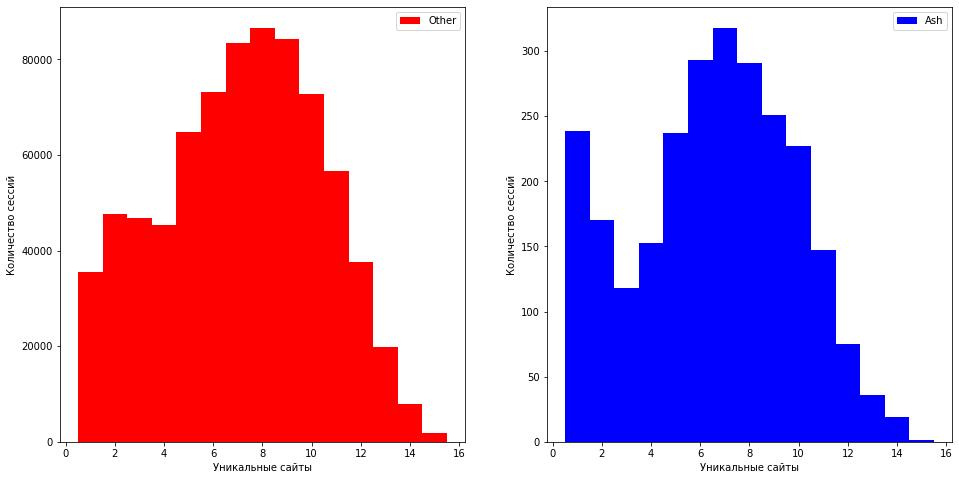

In [26]:
color = ['red','blue']
labels = ['Other', 'Ash']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
for idx, (user, sub_df) in  enumerate(df_fe.groupby('user')): 
    a, b = idx // 2, idx % 2
    axes[user].hist(sub_df.unique_sites, color = color[user], label = labels[user], bins=np.arange(1,17)-0.5)    
    axes[user].legend()
    axes[user].set_xlabel('Уникальные сайты')
    axes[user].set_ylabel('Количество сессий')

Гистограммы похожи, Ash отличается большим количеством сессий с маленьким числом уникальных сайтов. Можно попробовать использовать этот признак. Но кажется, что пользы от этого сильно не будет

Построим гистограмму распределения времени начала сессии.

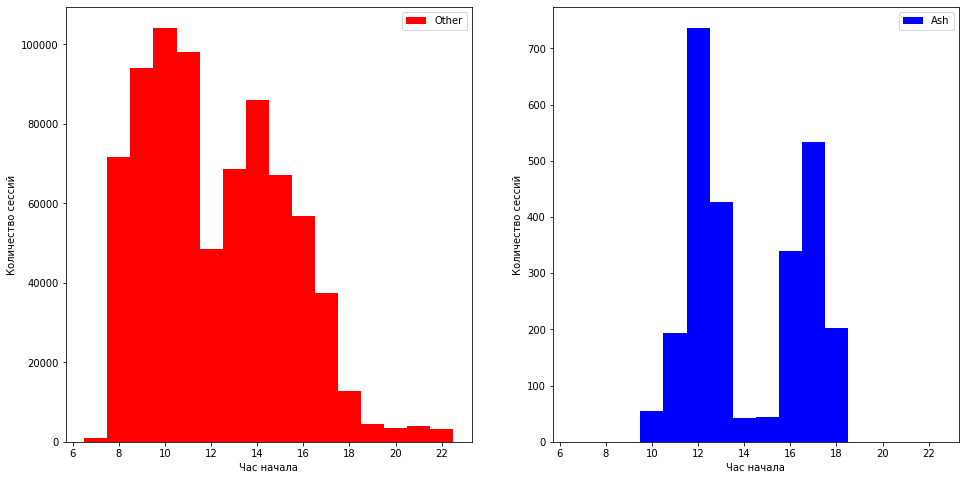

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
for idx, (user, sub_df) in  enumerate(df_fe.groupby('user')): 
    a, b = idx // 2, idx % 2
    axes[user].hist(sub_df.start_hour, color = color[user], label = labels[user], bins=np.arange(7,24)-0.5)    
    axes[user].legend()
    axes[user].set_xlabel('Час начала')
    axes[user].set_ylabel('Количество сессий')

А вот это отличный признак! Видно какое время характерно для Asha. Этот признак мы точно оставим.

Построим гистограмму распределения дня недели, в который произошло начало сессии.

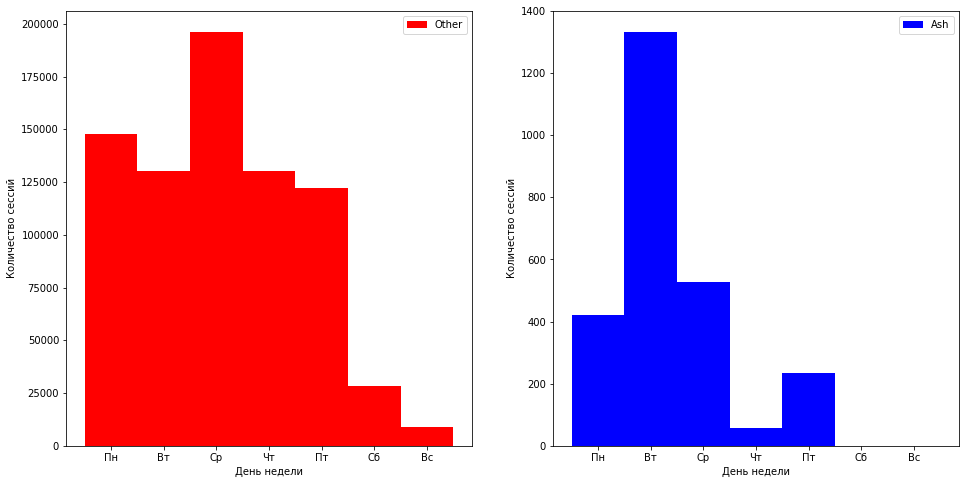

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ticks = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
for idx, (user, sub_df) in  enumerate(df_fe.groupby('user')): 
    a, b = idx // 2, idx % 2
    axes[user].hist(sub_df.day_of_week, color = color[user], label = labels[user], bins=np.arange(0,8)-0.5)    
    axes[user].legend()
    axes[user].set_xticks(np.arange(7))
    axes[user].set_xticklabels(ticks)
    axes[user].set_xlabel('День недели')
    axes[user].set_ylabel('Количество сессий')

Тоже хороший признак. Видим,что Ash совсем не заходит в интернет в выходные дни и редко заходит в четверг. Зато часто заходит во вторник

Построим гистограмму распределения дня (в месяце), в который произошло начало сессии.

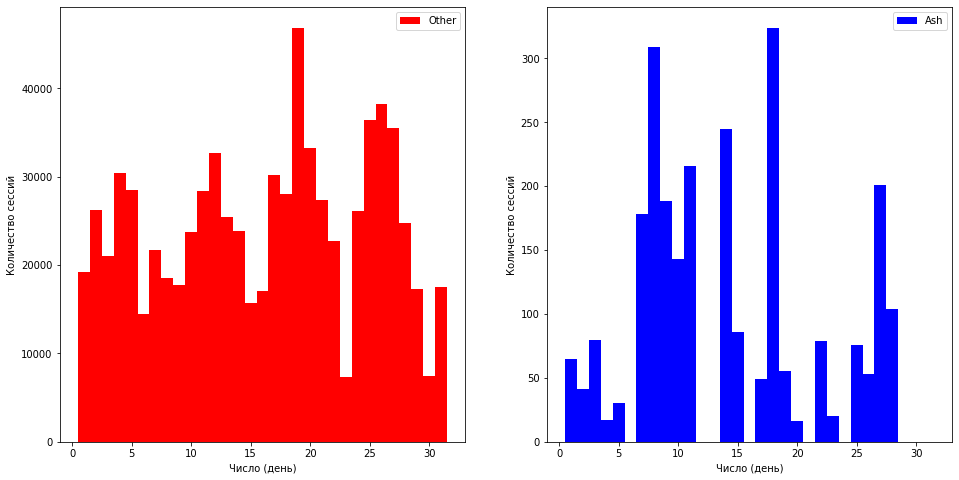

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
for idx, (user, sub_df) in  enumerate(df_fe.groupby('user')): 
    a, b = idx // 2, idx % 2
    axes[user].hist(sub_df.day, color = color[user], label = labels[user], bins=np.arange(1,33)-0.5)    
    axes[user].legend()
    axes[user].set_xlabel('Число (день)')
    axes[user].set_ylabel('Количество сессий')

В начале месяца Ash реже заходит в интернет. Возможно мы сможем это как-то использовать. Но, так как в нашей выборке не так много месяцев, сложно делать выводы по этому признаку

Построим гистограмму распределения продолжительности сессии.

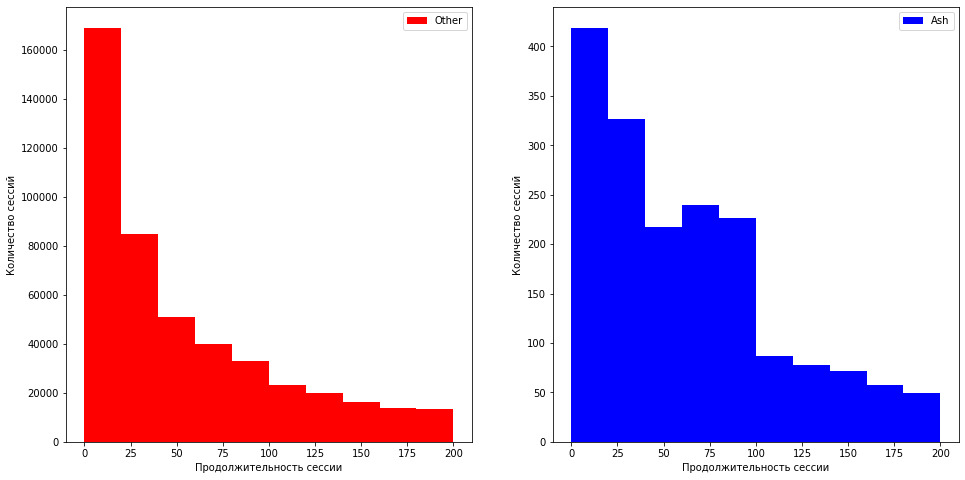

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
for idx, (user, sub_df) in  enumerate(df_fe.groupby('user')): 
    a, b = idx // 2, idx % 2
    axes[user].hist(sub_df.session_timespan, color = color[user], label = labels[user], range = (0,200))    
    axes[user].legend()
    axes[user].set_xlabel('Продолжительность сессии')
    axes[user].set_ylabel('Количество сессий')

Для Asha характерно большее количество коротких сессий. Можно попробовать использовать этот признак

Исходя из визуального анализа наших данных, можно выделить:
- start_hour, day_of_week - сильные признаки, их мы точно оставим
- unique_sites, day, session_timespan - сложно сказать будут ли работать эти признаки, надо пробовать

## Обучение модели

Обучим нашу первую модель!
Мы решаем задачу бинарной классификации, так что в качестве классификатора будем пробовать:
- логистическая регрессия, обучаемые стохастическим градиентным спуском SGDClassifier
- адаптивный бустинг AdaBoostClassifier
- наивный Байес MultinomialNB

Оценить модель будем с помощью roc_auc_score — площадь (Area Under Curve) под кривой ошибок (Receiver Operating Characteristic curve ). Данная кривая представляет из себя линию от (0,0) до (1,1) в координатах True Positive Rate (TPR) и False Positive Rate (FPR)


Разделим наши данные на три части не перемешивая, так как они отсортированы по времени

- X_train, y_train - на ней мы будем обучать наши модели
- X_valid, y_valid - на этой части мы будем проверять работу нашей модели
- X_test, y_test - на этой части будет проводить финальное тестирование модели

In [ ]:
def split(train_test_sparse, df_fe):
    test_share = int(.75 * train_test_sparse.shape[0])
    train_sparse, test_sparse = train_test_sparse[:test_share, :], train_test_sparse[test_share:, :]
    train_df_fe, test_df_fe = df_fe.iloc[:test_share, :-1], df_fe.iloc[test_share:, :-1]
    train_user = df_fe.user[:test_share]

    train_share = int(.75 * train_sparse.shape[0])
    X_train_concat = hstack((train_sparse, train_df_fe.values))
    X_train_concat = csr_matrix(X_train_concat)
    X_train, X_valid = X_train_concat[:train_share, :], X_train_concat[train_share:, :]
    y_train, y_valid = train_user[:train_share], train_user[train_share:]

    X_test = hstack((test_sparse, test_df_fe.values))
    X_test = csr_matrix(X_test)
    y_test = df_fe.user[test_share:]
    
    return(X_train, y_train, X_valid, y_valid, X_test, y_test)

Для начала обучим классификаторы с двумя дополнительными признаками start_hour, day_of_week. Эти признаки нужно привести к бинарному виду с помощью OneHotEncoder.

In [178]:
onehot_encoder = OneHotEncoder(sparse=False)
df_fe1 = pd.DataFrame(onehot_encoder.fit_transform(df_fe.iloc[:,:2]))
df_fe1['user'] = [1 if x==600 else 0 for x in train_test_data.user]

In [179]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split(train_test_sparse, df_fe1)

Посмотрим какого размера выборки у нас получились

In [65]:
print(*X_train.shape)
print(*X_valid.shape)
print(*X_test.shape)

431383 196814
143795 196814
191726 196814


Зададим тип кросс-валидации: 5-кратная, с перемешиванием

In [75]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV

In [71]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [74]:
sgd = SGDClassifier(loss='log', n_jobs=-1)
cross_val_score(sgd, X_train, y_train, cv=skf).mean()

0.996290999271997

In [77]:
adaboost = AdaBoostClassifier(n_estimators=100)
cross_val_score(adaboost, X_train, y_train, cv=skf).mean()

0.9964648585350224

In [76]:
bayes = MultinomialNB()
cross_val_score(bayes, X_train, y_train, cv=skf).mean()

0.9942695937747457

Результаты всех классификаторов выглядят впечатляюще. Посмотрим как они покажут себя на нашей контрольной выборке

In [83]:
sgd.fit(X_train, y_train)
adaboost.fit(X_train, y_train)
bayes.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [85]:
print('SGDClassifier -', round(roc_auc_score(y_valid, sgd.predict_proba(X_valid)[:,1]),3))
print('AdaBoostClassifier -', round(roc_auc_score(y_valid, adaboost.predict_proba(X_valid)[:,1]),3))
print('MultinomialNB -', round(roc_auc_score(y_valid, bayes.predict_proba(X_valid)[:,1]),3))

SGDClassifier - 0.933
AdaBoostClassifier - 0.893
MultinomialNB - 0.751


Результаты ожидаемо стали хуже. Можно сделать вывод, что логистическая регрессия работает лучше всего.
Попробуем улучшить результат регрессии, поэкспериментировав с параметрами модели при помощи GridSearchCV.

0.941


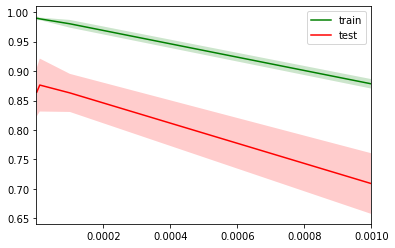

In [119]:
param = {'alpha': [0.000001,0.00001,0.0001,0.001]}
sgd = GridSearchCV(SGDClassifier(loss='log',n_jobs=-1), param_grid=param, scoring='roc_auc', return_train_score=True)
sgd.fit(X_train, y_train)
print(round(roc_auc_score(y_valid, sgd.best_estimator_.predict_proba(X_valid)[:,1]),3))
plot_validation_curves(param['alpha'], sgd.cv_results_)
plt.xlim((1.e-07,1.e-03))
plt.show()

0.922


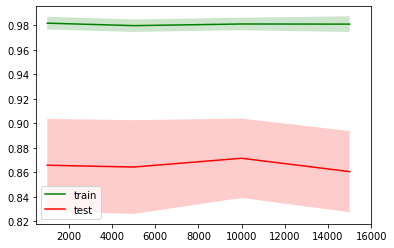

In [121]:
param = {'max_iter': [1000,5000,10000,15000]}
sgd = GridSearchCV(SGDClassifier(loss='log',n_jobs=-1), param_grid=param, scoring='roc_auc', return_train_score=True)
sgd.fit(X_train, y_train)
print(round(roc_auc_score(y_valid, sgd.best_estimator_.predict_proba(X_valid)[:,1]),3))
plot_validation_curves(param['max_iter'], sgd.cv_results_)
plt.xlim((500,16000))
plt.show()

0.926


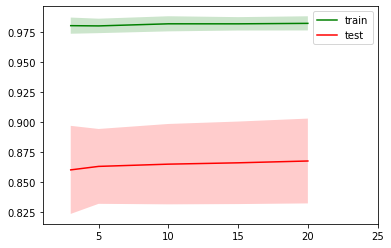

In [122]:
param = {'n_iter_no_change':[3,5,10,15,20]}
sgd = GridSearchCV(SGDClassifier(loss='log',n_jobs=-1), param_grid=param, scoring='roc_auc', return_train_score=True)
sgd.fit(X_train, y_train)
print(round(roc_auc_score(y_valid, sgd.best_estimator_.predict_proba(X_valid)[:,1]),3))
plot_validation_curves(param['n_iter_no_change'], sgd.cv_results_)
plt.xlim((1,25))
plt.show()

Исходя из данных графиков, уменьшим диапазон выбираемых параметров и переберем их все сразу. 

In [180]:
param = {'alpha': [0.000001,0.00001], 'max_iter': [10000], 'n_iter_no_change':[10,15]}
sgd = GridSearchCV(SGDClassifier(loss='log',n_jobs=-1), param_grid=param, scoring='roc_auc', return_train_score=True)
sgd.fit(X_train, y_train)
print(round(roc_auc_score(y_valid, sgd.best_estimator_.predict_proba(X_valid)[:,1]),3))

0.941


In [181]:
sgd.best_estimator_

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=10, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Результат немного улучшился. Запомним лучшие параметры модели.
Чтобы снизить элемент случайности обучим модель 10 раз и усредним результат.

In [182]:
roc_auc=[]
for i in range(10):
    sgd.best_estimator_.fit(X_train, y_train)
    roc_auc.append(round(roc_auc_score(y_valid, sgd.best_estimator_.predict_proba(X_valid)[:,1]),3))
np.mean(roc_auc)

0.9391999999999999

У нас еще остались признаки, которые мы не использовали, попробуем их добавить.
Для начала unique_sites. 

In [183]:
onehot_encoder = OneHotEncoder(sparse=False)
df_fe2 = pd.DataFrame(onehot_encoder.fit_transform(df_fe.iloc[:,:3]))
df_fe2['user'] = [1 if x==600 else 0 for x in train_test_data.user]

In [184]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split(train_test_sparse, df_fe2)

In [185]:
roc_auc=[]
for i in range(10):
    sgd.best_estimator_.fit(X_train, y_train)
    roc_auc.append(round(roc_auc_score(y_valid, sgd.best_estimator_.predict_proba(X_valid)[:,1]),3))
np.mean(roc_auc)

0.9376999999999999

Результат немного ухудшился, не будем оставлять этот признак. Посмотрим на признак day



In [187]:
onehot_encoder = OneHotEncoder(sparse=False)
df_fe3 = pd.DataFrame(onehot_encoder.fit_transform(df_fe.iloc[:,[0,1,3]]))
df_fe3['user'] = [1 if x==600 else 0 for x in train_test_data.user]

In [188]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split(train_test_sparse, df_fe3)

In [189]:
roc_auc=[]
for i in range(10):
    sgd.best_estimator_.fit(X_train, y_train)
    roc_auc.append(round(roc_auc_score(y_valid, sgd.best_estimator_.predict_proba(X_valid)[:,1]),3))
np.mean(roc_auc)

0.8558

Результат стал намного хуже, этого следовало ожидать. 

Попробуем признак session_timespan. Для нашего пользователя выделялся диапазон 50-100 секунд, закодируем его как 1. Остальное время будет 0.  

In [191]:
onehot_encoder = OneHotEncoder(sparse=False)
df_fe4 = pd.DataFrame(onehot_encoder.fit_transform(df_fe.iloc[:,[0,1]]))
df_fe4['session_timespan'] = [1 if x in range(50,100) else 0 for x in df_fe.session_timespan]
df_fe4['user'] = [1 if x==600 else 0 for x in train_test_data.user]

In [194]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split(train_test_sparse, df_fe4)

In [195]:
roc_auc=[]
for i in range(10):
    sgd.best_estimator_.fit(X_train, y_train)
    roc_auc.append(round(roc_auc_score(y_valid, sgd.best_estimator_.predict_proba(X_valid)[:,1]),3))
np.mean(roc_auc)

0.9366

Результат опять не улучшился. 
Можно сделать вывод, что мы правильно оценили наши признаки по визуальному представлению.

In [202]:
onehot_encoder = OneHotEncoder(sparse=False)
df_fe1 = pd.DataFrame(onehot_encoder.fit_transform(df_fe.iloc[:,:2]))
df_fe1['user'] = [1 if x==600 else 0 for x in train_test_data.user]

In [267]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split(train_test_sparse, df_fe1)

Проверим нашу модель на тестовой выборке

In [268]:
X_train_final = vstack((X_train,X_valid))
X_train_final = csr_matrix(X_train_final)
y_final = pd.concat((y_train, y_valid), axis=0)

roc_auc=[]
for i in range(10):
    sgd.best_estimator_.fit(X_train_final, y_final)
    roc_auc.append(round(roc_auc_score(y_test, sgd.best_estimator_.predict_proba(X_test)[:,1]),3))
np.mean(roc_auc)


Результат расстраивает. Посмотрим какой результат можно получить использую нелинейную модель

In [270]:
adaboost = AdaBoostClassifier(n_estimators=100)
adaboost.fit(X_train_final, y_final)
print(round(roc_auc_score(y_test, adaboost.predict_proba(X_test)[:,1]),3))

0.876


Бустинг работает даже лучше.

Поищем способы улучшить наши предсказания. Возможно этого можно достигнуть используя кодирование индексов сайтов при помощи CountVectorizer. Этот метод позволит использовать не только сами индексы, но и их сочетания - nграммы.

In [207]:
from sklearn.feature_extraction.text import CountVectorizer

In [211]:
str_site=[]
for i in train_test_data.iloc[:,15:30].values:
    str_site += [str(i).replace('\n','')[1:-1]]    

In [221]:
matrix = CountVectorizer(ngram_range=(1,2)).fit(str_site)
train_test_vec = matrix.transform(str_site)

In [245]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split(X, df_fe1)

In [223]:
roc_auc=[]
for i in range(10):
    sgd.best_estimator_.fit(X_train, y_train)
    roc_auc.append(round(roc_auc_score(y_valid, sgd.best_estimator_.predict_proba(X_valid)[:,1]),3))
np.mean(roc_auc)

0.9599

На контрольной выборке наша модель стала работать лучше. Проверим на тестовой

In [246]:
X_train_final = vstack((X_train,X_valid))
X_train_final = csr_matrix(X_train_final)
y_final = pd.concat((y_train, y_valid), axis=0)

roc_auc=[]
for i in range(10):
    sgd.best_estimator_.fit(X_train_final, y_final)
    roc_auc.append(round(roc_auc_score(y_test, sgd.best_estimator_.predict_proba(X_test)[:,1]),3))
np.mean(roc_auc)

0.8187999999999999

Результат стал только хуже. 
Вернемся к представлению индексов сайтов через разреженную матрицу и попробуем использовать результаты работы sgd модели в качестве дополнительного признака для обучения адаптивного бустинга.

In [259]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split(train_test_sparse, df_fe1)

In [260]:
X_train_final = vstack((X_train,X_valid))
X_train_final = csr_matrix(X_train_final)
y_final = pd.concat((y_train, y_valid), axis=0)

In [261]:
sepr = int(X_train_final.shape[0]/2)
sgd.best_estimator_.fit(X_train_final[:sepr,:], y_final[:sepr])
sgd2 = sgd.best_estimator_.predict(X_train_final[sepr:,:])

In [262]:
sgd.best_estimator_.fit(X_train_final[sepr:,:], y_final[sepr:])
sgd1 = sgd.best_estimator_.predict(X_train_final[:sepr,:])

In [263]:
sgd.best_estimator_.fit(X_train_final, y_final)
sgd_test = sgd.best_estimator_.predict(X_test)

In [264]:
onehot_encoder = OneHotEncoder(sparse=False)
df_fe5 = pd.DataFrame(onehot_encoder.fit_transform(df_fe.iloc[:,:2]))
df_fe5['sgd'] = np.concatenate([np.concatenate([sgd1,sgd2]), sgd_test])
df_fe5['user'] = [1 if x==600 else 0 for x in train_test_data.user]

In [265]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split(X, df_fe5)

In [266]:
X_train_final = vstack((X_train,X_valid))
X_train_final = csr_matrix(X_train_final)
y_final = pd.concat((y_train, y_valid), axis=0)

adaboost = AdaBoostClassifier(n_estimators=100)
adaboost.fit(X_train_final, y_final)
print(round(roc_auc_score(y_test, adaboost.predict_proba(X_test)[:,1]),3))

0.826


Результат стал хуже

## Заключение

В процессе работы мы попробовали несколько моделей классификации с разными параметрами и различными признаками. Лучшая точность идентификации пользователя, которую нам удалось получить 0.876 по кривой roc-auc. Результат не очень впечатляющий. Возможно данных за 6.5 месяцев, недостаточно для того, чтобы отследить зависимости в данных.